In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr


In [2]:
ds = xr.open_dataset(Path("../data_original/spectra_coh_LES.nc"))
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (radius: 1, height: 60, frequency: 3001,
                         spatialSeparation: 26, frequency_coh: 221)
Coordinates:
  * radius              (radius) float64 8B 0.9798
  * height              (height) float64 480B 1.974 6.413 11.34 ... 285.7 290.6
  * frequency           (frequency) float64 24kB 0.0 0.001667 ... 4.998 5.0
  * spatialSeparation   (spatialSeparation) float64 208B 0.0 11.11 ... 179.5
  * frequency_coh       (frequency_coh) float64 2kB 0.0 0.004539 ... 0.9986
Data variables:
    spectralDensity_u   (radius, height, frequency) float64 1MB ...
    spectralDensity_v   (radius, height, frequency) float64 1MB ...
    spectralDensity_w   (radius, height, frequency) float64 1MB ...
    spectralDensity_uu  (radius, height, frequency) float64 1MB ...
    spectralDensity_vv  (radius, height, frequency) float64 1MB ...
    spectralDensity_ww  (radius, height, frequency) float64 1MB ...
    spectralDensity_uw  (radius, height, f

# One-point spectra data

In [3]:
# Coordinates for spectra
radius_ds = np.array(ds['radius'])
height_ds = np.array(ds['height'])
freq_ds = np.array(ds['frequency'])

fUU_ds = np.array(ds['spectralDensity_uu'])
fVV_ds = np.array(ds['spectralDensity_vv'])
fWW_ds = np.array(ds['spectralDensity_ww'])
fUW_ds = np.array(ds['spectralDensity_uw'])
fUV_ds = np.array(ds['spectralDensity_uv'])
fVW_ds = np.array(ds['spectralDensity_vw'])


In [4]:
# Grab a particular height
height_ind = len(height_ds) // 2

print("Selected height (use as zref?): ", height_ds[height_ind])

# Get spectra at that height
freq_h = freq_ds.copy()
# NOTE: We need the 0 in first index
fUU_h = np.squeeze(fUU_ds[0, height_ind, :])
fVV_h = np.squeeze(fVV_ds[0, height_ind, :])
fWW_h = np.squeeze(fWW_ds[0, height_ind, :])
fUW_h = np.squeeze(fUW_ds[0, height_ind, :])
fUV_h = np.squeeze(fUV_ds[0, height_ind, :])
fVW_h = np.squeeze(fVW_ds[0, height_ind, :])


Selected height (use as zref?):  148.56202535609793


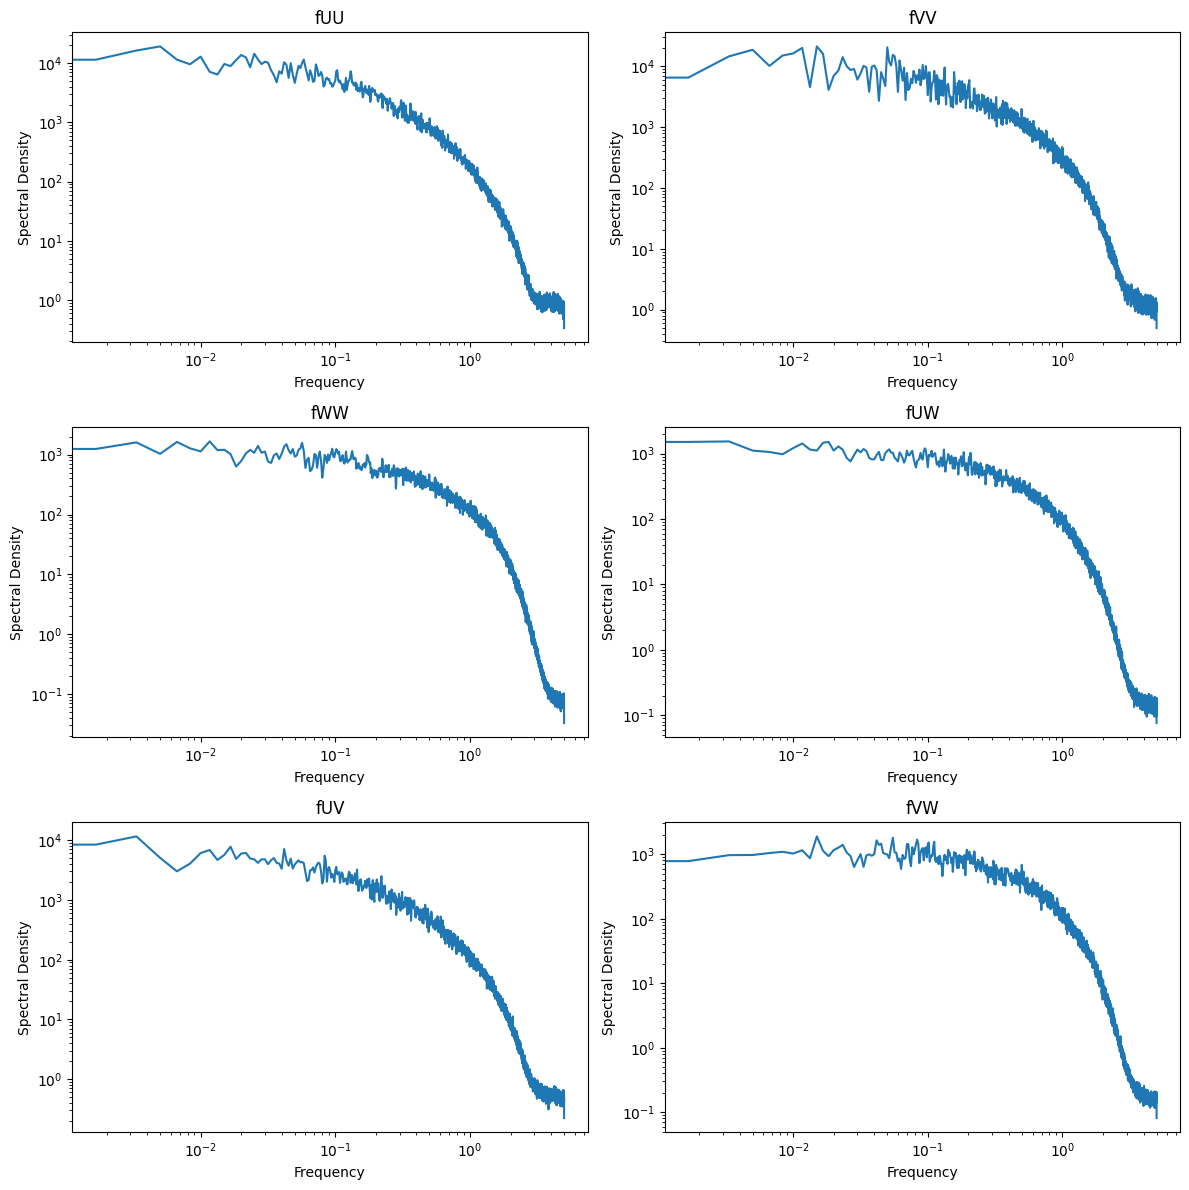

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

axs[0].loglog(freq_h, fUU_h)
axs[0].set_title('fUU')
axs[1].loglog(freq_h, fVV_h)
axs[1].set_title('fVV')
axs[2].loglog(freq_h, fWW_h)
axs[2].set_title('fWW')
axs[3].loglog(freq_h, fUW_h)
axs[3].set_title('fUW')
axs[4].loglog(freq_h, fUV_h)
axs[4].set_title('fUV')
axs[5].loglog(freq_h, fVW_h)
axs[5].set_title('fVW')

for ax in axs:
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Spectral Density')

plt.tight_layout()
plt.show()




In [6]:
# NOTE: Copied from older data_clean.ipynb
def clean_spectra(
    frequency,
    uu,
    vv,
    ww,
    uw,
    vw,
    uv,
    threshold=1.0,
    buffer_points=10
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Clean all spectral components using a common cutoff point.
    
    Parameters
    ----------
    frequency : np.ndarray
        The frequency values (3001,)
    uu, vv, ww, uw : np.ndarray
        The spectral components (each 3001,)
    threshold : float, optional
        The threshold value below which to cut off (default: 1.0)
    buffer_points : int, optional
        Number of points to keep before the cutoff for smooth transition
        
    Returns
    -------
    cleaned_freq : np.ndarray
        The cleaned frequency array
    cleaned_uu, cleaned_vv, cleaned_ww, cleaned_uw : np.ndarray
        The cleaned spectral components
    """
    # Find where each component drops below threshold
    cutoff_idx_uu = np.where(uu < threshold)[0][0] if np.any(uu < threshold) else len(uu)
    cutoff_idx_vv = np.where(vv < threshold)[0][0] if np.any(vv < threshold) else len(vv)
    cutoff_idx_ww = np.where(ww < threshold)[0][0] if np.any(ww < threshold) else len(ww)
    
    # For uw (cross-spectrum), use absolute value since it can be negative
    cutoff_idx_uw = np.where(np.abs(uw) < threshold/10)[0][0] if np.any(np.abs(uw) < threshold/10) else len(uw)
    cutoff_idx_vw = np.where(np.abs(vw) < threshold/10)[0][0] if np.any(np.abs(vw) < threshold/10) else len(vw)
    cutoff_idx_uv = np.where(np.abs(uv) < threshold/10)[0][0] if np.any(np.abs(uv) < threshold/10) else len(uv)
    
    # Take the earliest cutoff point to ensure all spectra are valid
    cutoff_idx = min(
        cutoff_idx_uu,
        cutoff_idx_vv,
        cutoff_idx_ww,
        cutoff_idx_uw,
        cutoff_idx_vw,
        cutoff_idx_uv
    )
    
    # Add buffer
    final_idx = max(0, cutoff_idx - buffer_points)
    
    # Return cleaned arrays
    return (frequency[:final_idx],
            uu[:final_idx],
            vv[:final_idx],
            ww[:final_idx],
            uw[:final_idx],
            vw[:final_idx],
            uv[:final_idx])

In [7]:
cleaned_freq_spectra = clean_spectra(
    frequency=freq_h,
    uu=fUU_h,
    vv=fVV_h,
    ww=fWW_h,
    uw=fUW_h,
    vw=fVW_h,
    uv=fUV_h
)

In [8]:
cfreq_h = cleaned_freq_spectra[0]
cfUU_h = cleaned_freq_spectra[1]
cfVV_h = cleaned_freq_spectra[2]
cfWW_h = cleaned_freq_spectra[3]
cfUW_h = cleaned_freq_spectra[4]
cfVW_h = cleaned_freq_spectra[5]
cfUV_h = cleaned_freq_spectra[6]

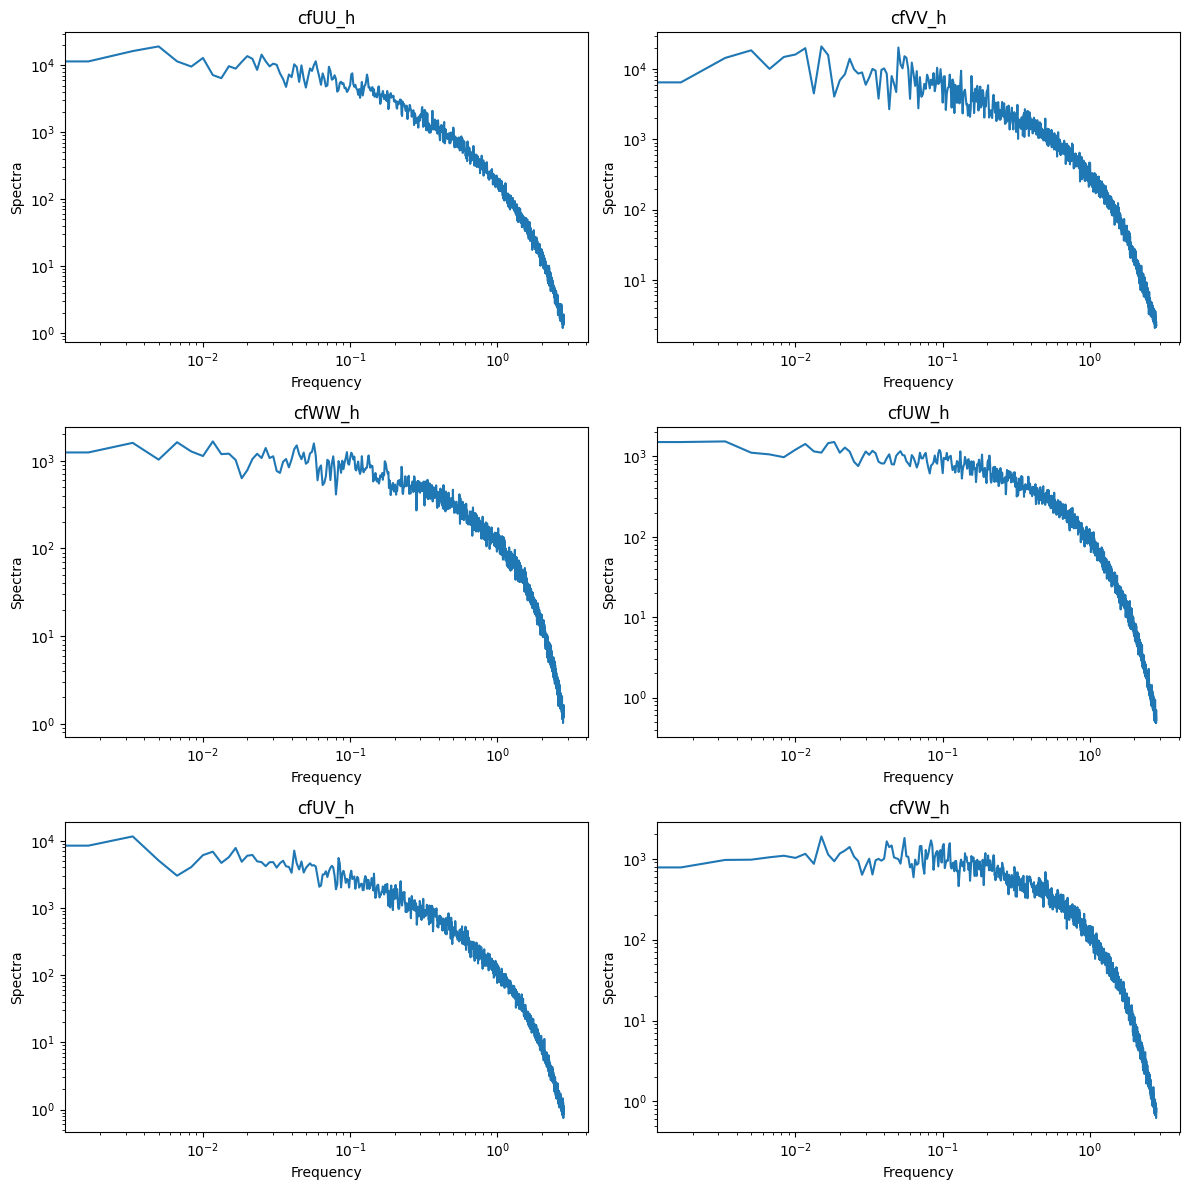

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].loglog(cfreq_h, cfUU_h)
axs[0, 0].set_title('cfUU_h')
axs[0, 0].set_ylabel('Spectra')
axs[0, 0].set_xlabel('Frequency')

axs[0, 1].loglog(cfreq_h, cfVV_h)
axs[0, 1].set_title('cfVV_h')
axs[0, 1].set_ylabel('Spectra')
axs[0, 1].set_xlabel('Frequency')

axs[1, 0].loglog(cfreq_h, cfWW_h)
axs[1, 0].set_title('cfWW_h')
axs[1, 0].set_ylabel('Spectra')
axs[1, 0].set_xlabel('Frequency')

axs[1, 1].loglog(cfreq_h, cfUW_h)
axs[1, 1].set_title('cfUW_h')
axs[1, 1].set_ylabel('Spectra')
axs[1, 1].set_xlabel('Frequency')

axs[2, 0].loglog(cfreq_h, cfUV_h)
axs[2, 0].set_title('cfUV_h')
axs[2, 0].set_ylabel('Spectra')
axs[2, 0].set_xlabel('Frequency')

axs[2, 1].loglog(cfreq_h, cfVW_h)
axs[2, 1].set_title('cfVW_h')
axs[2, 1].set_ylabel('Spectra')
axs[2, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()



In [10]:
weighted_uu = cfUU_h * cfreq_h
weighted_vv = cfVV_h * cfreq_h
weighted_ww = cfWW_h * cfreq_h
weighted_uw = cfUW_h * cfreq_h
weighted_vw = cfVW_h * cfreq_h
weighted_uv = cfUV_h * cfreq_h

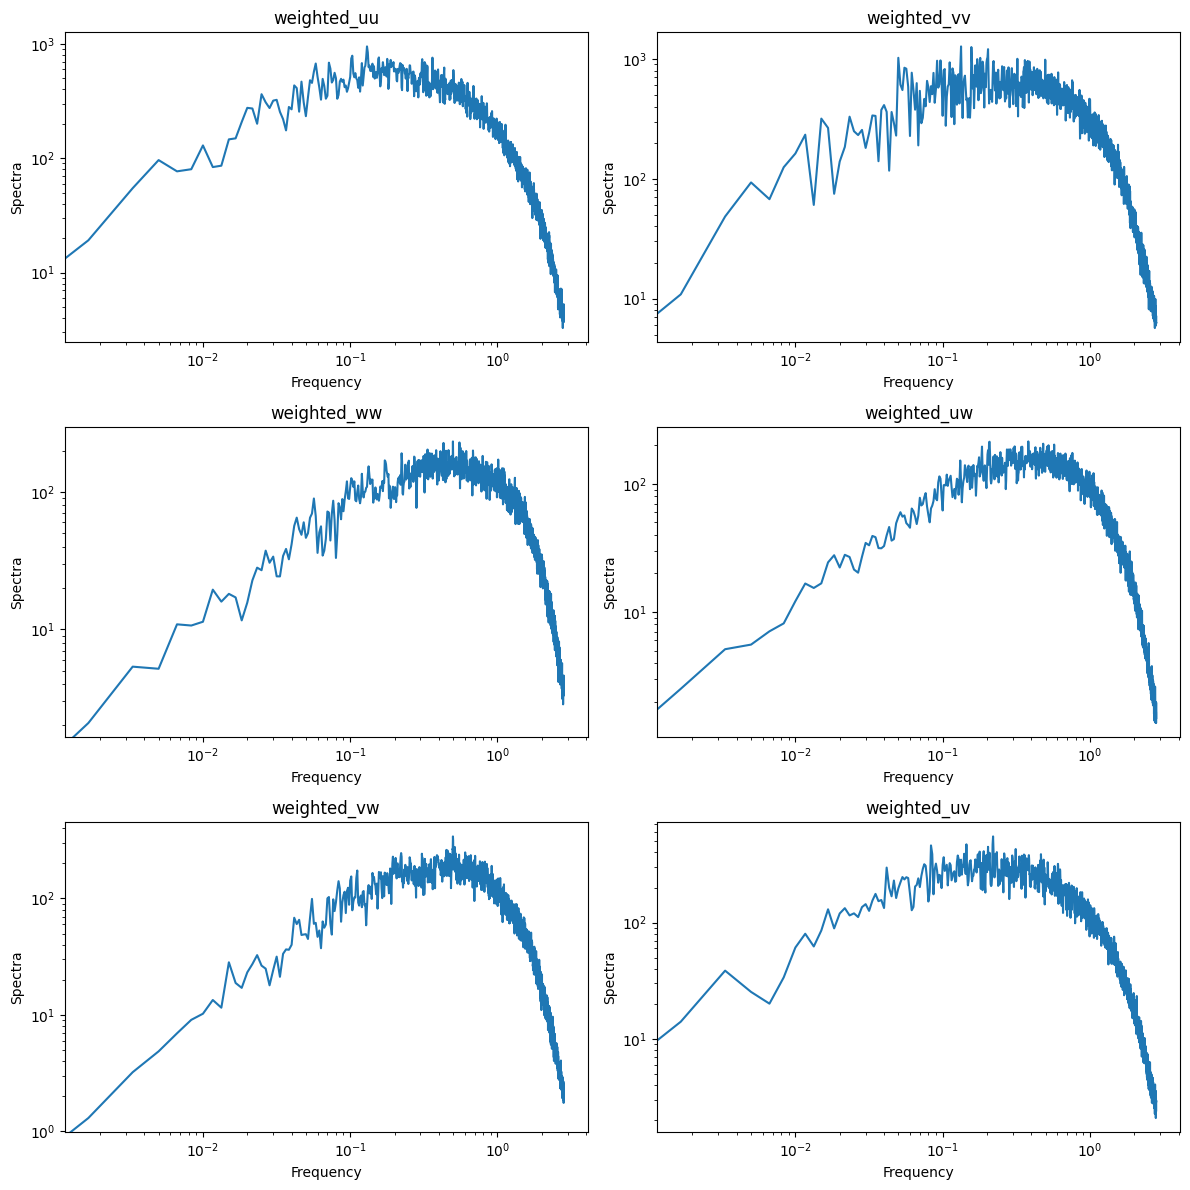

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].loglog(cfreq_h, weighted_uu)
axs[0, 0].set_title('weighted_uu')
axs[0, 0].set_ylabel('Spectra')
axs[0, 0].set_xlabel('Frequency')

axs[0, 1].loglog(cfreq_h, weighted_vv)
axs[0, 1].set_title('weighted_vv')
axs[0, 1].set_ylabel('Spectra')
axs[0, 1].set_xlabel('Frequency')

axs[1, 0].loglog(cfreq_h, weighted_ww)
axs[1, 0].set_title('weighted_ww')
axs[1, 0].set_ylabel('Spectra')
axs[1, 0].set_xlabel('Frequency')

axs[1, 1].loglog(cfreq_h, weighted_uw)
axs[1, 1].set_title('weighted_uw')
axs[1, 1].set_ylabel('Spectra')
axs[1, 1].set_xlabel('Frequency')

axs[2, 0].loglog(cfreq_h, weighted_vw)
axs[2, 0].set_title('weighted_vw')
axs[2, 0].set_ylabel('Spectra')
axs[2, 0].set_xlabel('Frequency')

axs[2, 1].loglog(cfreq_h, weighted_uv)
axs[2, 1].set_title('weighted_uv')
axs[2, 1].set_ylabel('Spectra')
axs[2, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# Write out FULL data to file with polars

full_data = pl.DataFrame(
    {
        "freq": cfreq_h,
        "uu": weighted_uu,
        "vv": weighted_vv,
        "ww": weighted_ww,
        "uw": weighted_uw,
        "vw": weighted_vw,
        "uv": weighted_uv,
    }
)

full_data.write_csv("../data_cleaned/STORM_high_fidelity_one_point_spectra.csv")

In [12]:
def log_downsample(freq, data_columns, points_per_decade=20):
    """Downsample data with logarithmic spacing."""
    # Ensure all inputs are numpy arrays
    freq = np.array(freq)
    data_arrays = [np.array(col) for col in data_columns]
    
    # Filter out any zero or negative values in frequency
    positive_mask = freq > 0
    if not np.all(positive_mask):
        freq = freq[positive_mask]
        data_arrays = [col[positive_mask] for col in data_arrays]
        
    # Calculate frequency decades (log10 ranges)
    min_freq, max_freq = np.min(freq), np.max(freq)
    
    # Add a small epsilon to min_freq to prevent log10(0)
    min_freq = max(min_freq, 1e-10)
    
    min_decade, max_decade = np.log10(min_freq), np.log10(max_freq)
    num_decades = max_decade - min_decade
    
    # Ensure num_decades is positive
    if num_decades <= 0:
        num_decades = 1.0  # Default to at least one decade
    
    # Calculate total number of points to keep
    total_points = int(np.ceil(points_per_decade * num_decades))
    
    # Ensure we have at least 2 points
    total_points = max(total_points, 2)
    
    # Create logarithmically spaced frequency points
    log_spaced_freq = np.logspace(min_decade, max_decade, total_points)
    
    # Find indices of original data points closest to these log-spaced points
    downsampled_indices = []
    for target_freq in log_spaced_freq:
        idx = np.argmin(np.abs(freq - target_freq))
        if idx not in downsampled_indices:  # Avoid duplicates
            downsampled_indices.append(idx)
    
    # Sort indices
    downsampled_indices.sort()
    
    # Return downsampled frequency and data arrays
    downsampled_freq = freq[downsampled_indices]
    downsampled_data = [col[downsampled_indices] for col in data_arrays]
    
    return downsampled_freq, downsampled_data


In [19]:
downsampled_freq, downsampled_data = log_downsample(
    cfreq_h, 
    [weighted_uu, weighted_vv, weighted_ww, weighted_uw, weighted_vw, weighted_uv],
    points_per_decade=40  # Adjust this
)

# Unpack the downsampled data
downsampled_uu, downsampled_vv, downsampled_ww, downsampled_uw, downsampled_vw, downsampled_uv = downsampled_data

In [20]:
downsampled_data = pl.DataFrame(
    {
        "freq": downsampled_freq,
        "uu": downsampled_uu,
        "vv": downsampled_vv,
        "ww": downsampled_ww,
        "uw": downsampled_uw,
        "vw": downsampled_vw,
        "uv": downsampled_uv,
    }
)

downsampled_data.write_csv("../data_cleaned/STORM_downsampled_one_point_spectra.csv")

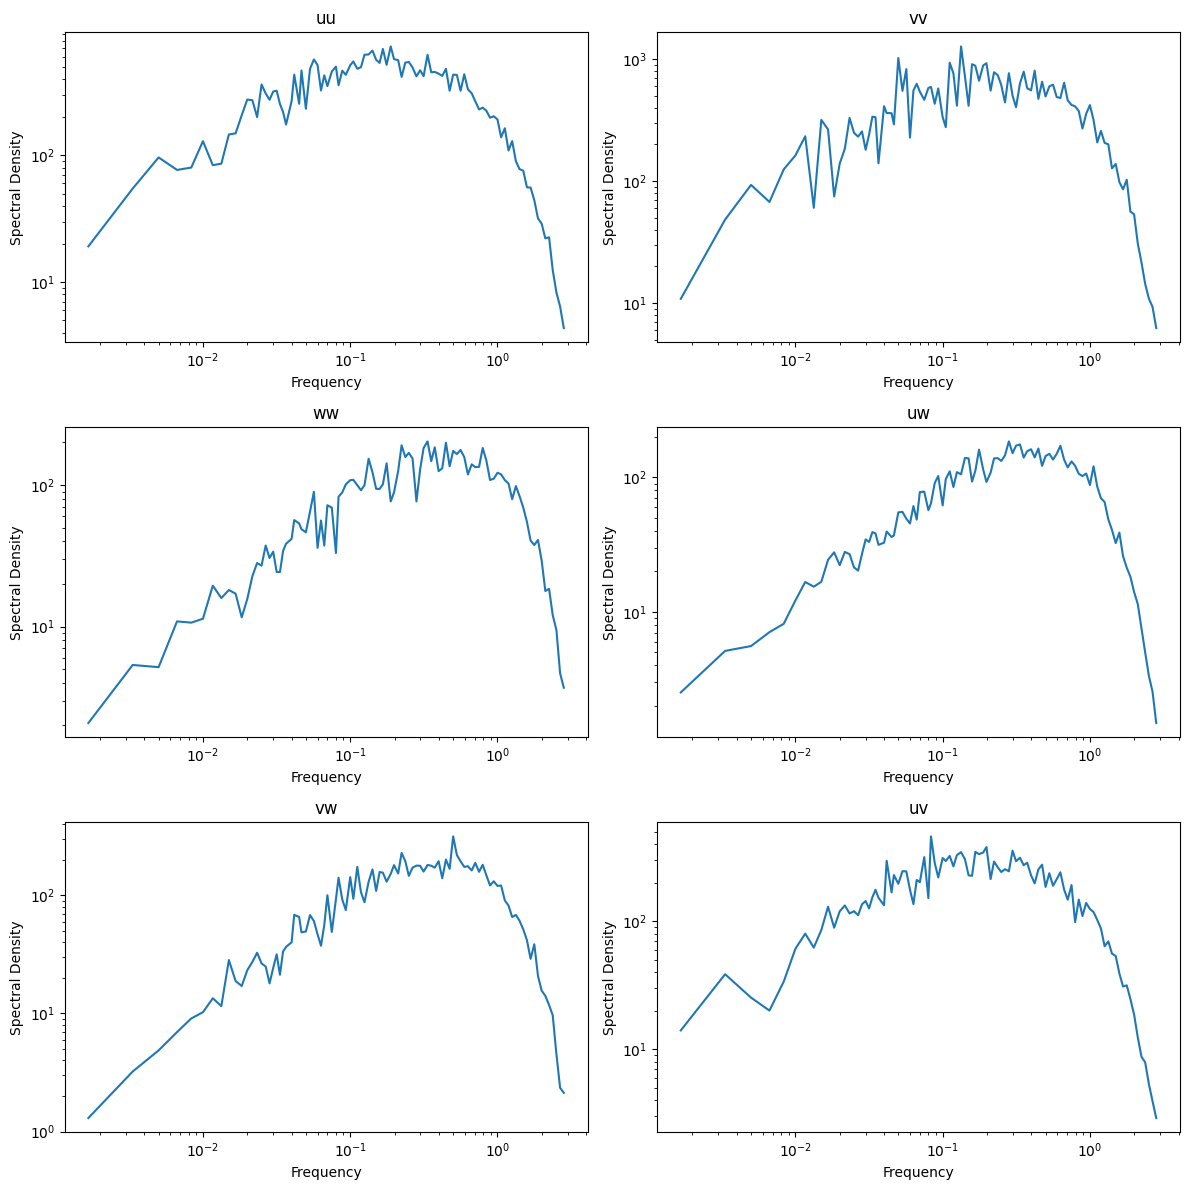

In [21]:
def plot_ops_df(ops_df):
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.flatten()

    axs[0].loglog(ops_df["freq"], ops_df["uu"])
    axs[0].set_title("uu")
    axs[1].loglog(ops_df["freq"], ops_df["vv"])
    axs[1].set_title("vv")
    axs[2].loglog(ops_df["freq"], ops_df["ww"])
    axs[2].set_title("ww")
    axs[3].loglog(ops_df["freq"], ops_df["uw"])
    axs[3].set_title("uw")
    axs[4].loglog(ops_df["freq"], ops_df["vw"])
    axs[4].set_title("vw")
    axs[5].loglog(ops_df["freq"], ops_df["uv"])
    axs[5].set_title("uv")

    for ax in axs:
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Spectral Density")

    plt.tight_layout()
    plt.show()

plot_ops_df(downsampled_data)

# Coherence Data

In [21]:
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (radius: 1, height: 60, frequency: 3001,
                         spatialSeparation: 26, frequency_coh: 221)
Coordinates:
  * radius              (radius) float64 8B 0.9798
  * height              (height) float64 480B 1.974 6.413 11.34 ... 285.7 290.6
  * frequency           (frequency) float64 24kB 0.0 0.001667 ... 4.998 5.0
  * spatialSeparation   (spatialSeparation) float64 208B 0.0 11.11 ... 179.5
  * frequency_coh       (frequency_coh) float64 2kB 0.0 0.004539 ... 0.9986
Data variables:
    spectralDensity_u   (radius, height, frequency) float64 1MB ...
    spectralDensity_v   (radius, height, frequency) float64 1MB ...
    spectralDensity_w   (radius, height, frequency) float64 1MB ...
    spectralDensity_uu  (radius, height, frequency) float64 1MB 2.215e+03 ......
    spectralDensity_vv  (radius, height, frequency) float64 1MB 534.9 ... 0.8316
    spectralDensity_ww  (radius, height, frequency) float64 1MB 0.01027 ... 0...
   

In [37]:
# NOTE: 4 is to remove the first 4 separations, since we want to use r >= 40m
spatialSeparation_ds = np.array(ds['spatialSeparation'])[4:]
print("Spatial separation range:", spatialSeparation_ds.min(), "to", spatialSeparation_ds.max())
print("Spatial separation shape:", spatialSeparation_ds.shape)

coh_freq_ds = np.array(ds['frequency_coh'])[1:] # NOTE: 1 is to remove the first frequency = 0.0
print("Frequency range:", coh_freq_ds.min(), "to", coh_freq_ds.max())
print("Frequency shape:", coh_freq_ds.shape)

coh_u_alongCross_ds = np.array(ds['coh_u_alongCross'])[4:,1:]
coh_v_alongCross_ds = np.array(ds['coh_v_alongCross'])[4:,1:]
coh_w_alongCross_ds = np.array(ds['coh_w_alongCross'])[4:,1:]
print("Coherence u function shape:", coh_u_alongCross_ds.shape)
print("Coherence v function shape:", coh_v_alongCross_ds.shape)
print("Coherence w function shape:", coh_w_alongCross_ds.shape)

assert not np.any(np.isnan(coh_u_alongCross_ds))
assert not np.any(np.isnan(coh_v_alongCross_ds))
assert not np.any(np.isnan(coh_w_alongCross_ds))

Spatial separation range: 40.06167931025693 to 179.50548672355896
Spatial separation shape: (22,)
Frequency range: 0.0045392646391284605 to 0.9986382206082614
Frequency shape: (220,)
Coherence u function shape: (22, 220)
Coherence v function shape: (22, 220)
Coherence w function shape: (22, 220)


In [38]:
rr, kk = np.meshgrid(spatialSeparation_ds, coh_freq_ds)

In [43]:
coherence_df = pl.DataFrame({
    "r": rr.flatten(),
    "freq": kk.flatten(),
    "coh_u": coh_u_alongCross_ds.flatten(),
    "coh_v": coh_v_alongCross_ds.flatten(),
    "coh_w": coh_w_alongCross_ds.flatten(),
})

coherence_df.write_csv("../data_cleaned/STORM_FULL_FIDELITY_coherence_data.csv")

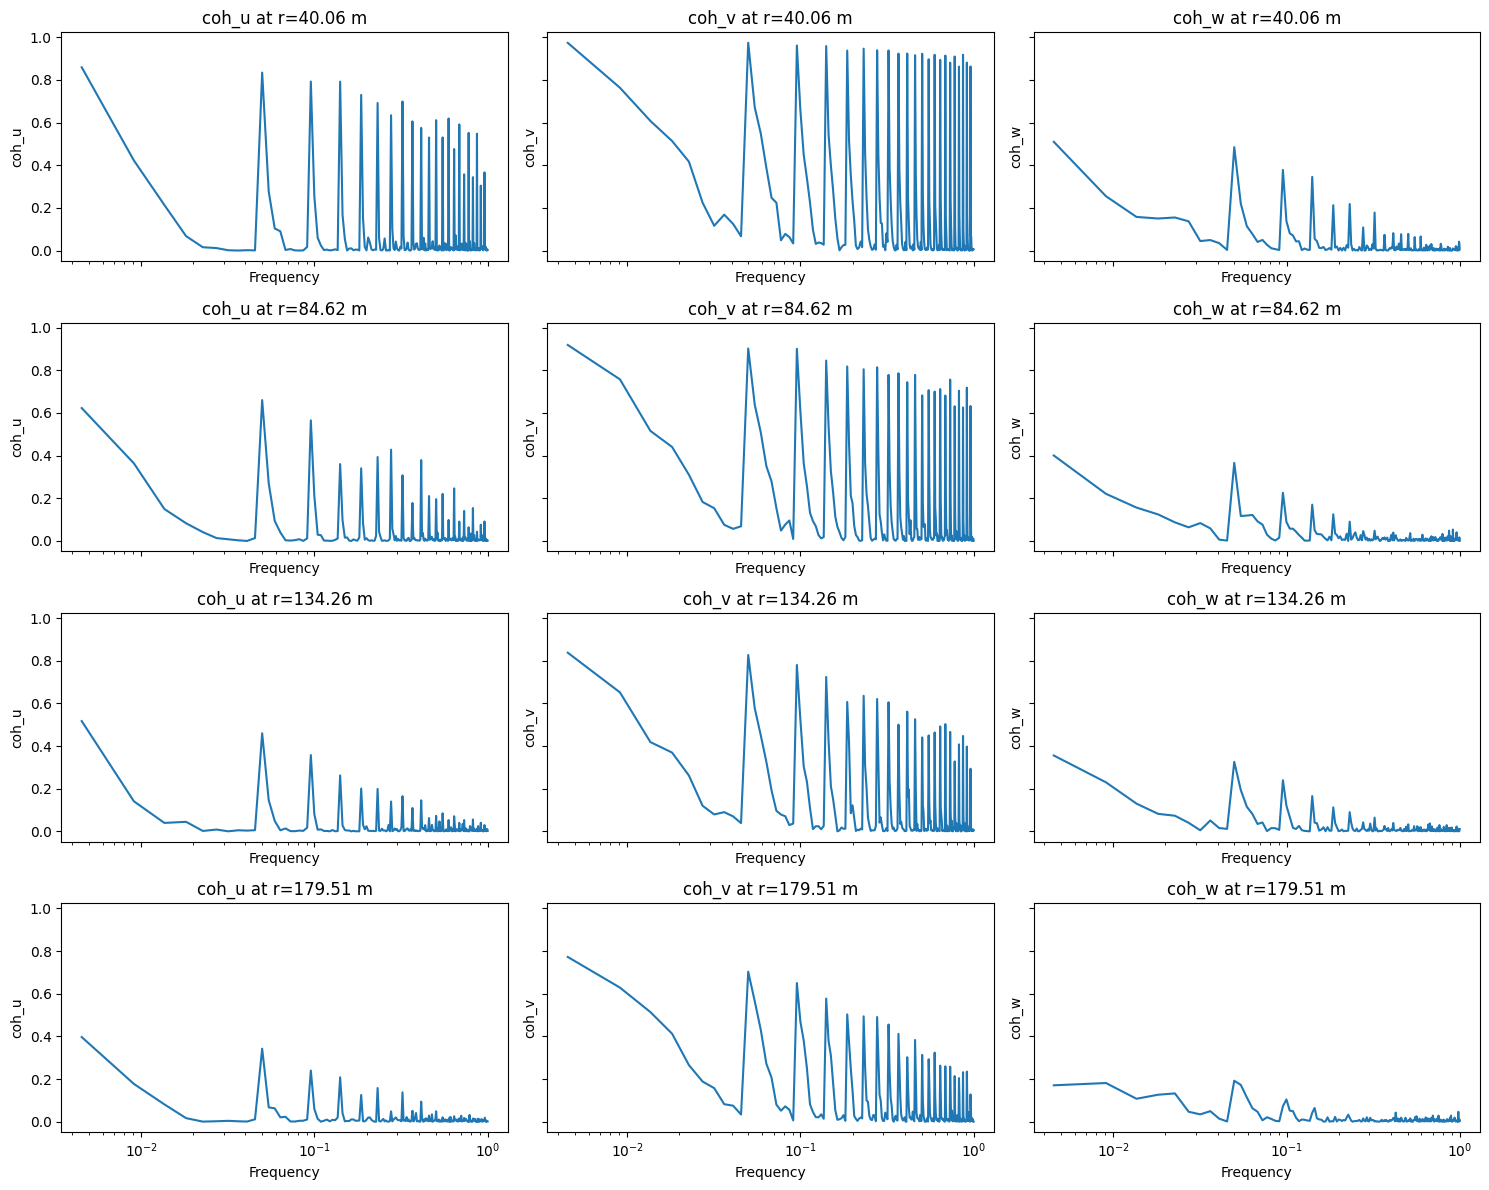

In [46]:
# TODO: Write a function to plot the coherence data... need to know how to access this


def plot_coherence_df(coherence_df, number_of_seps=4):
    """Plot the coherence data for coh_u, coh_v, coh_w in number_of_seps rows against frequency."""
    import matplotlib.pyplot as plt
    import numpy as np

    coherence_df = coherence_df.sort("freq")

    comps = ["coh_u", "coh_v", "coh_w"]
    unique_r = np.unique(coherence_df["r"].to_numpy())
    assert number_of_seps <= len(unique_r)

    selected_r = np.linspace(unique_r.min(), unique_r.max(), number_of_seps)
    selected_r = [unique_r[np.abs(unique_r - r_val).argmin()] for r_val in selected_r]

    fig, axs = plt.subplots(number_of_seps, 3, figsize=(15, 3 * number_of_seps), sharex=True, sharey=True)

    for i, r_val in enumerate(selected_r):
        mask = coherence_df["r"] == r_val
        for j, comp in enumerate(comps):
            ax = axs[i, j] if number_of_seps > 1 else axs[j]
            freq = coherence_df.filter(mask)["freq"].to_numpy()
            coh = coherence_df.filter(mask)[comp].to_numpy()
            ax.plot(freq, coh)
            ax.set_xscale("log")
            ax.set_xlabel("Frequency")
            ax.set_ylabel(comp)
            ax.set_title(f"{comp} at r={r_val:.2f} m")
    plt.tight_layout()
    plt.show()

    plt.show()

plot_coherence_df(coherence_df)



